In [30]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from astropy.table import Table

In [31]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [32]:
pd.read_tsv?

Object `pd.read_tsv` not found.


Text(0.5, 1.0, 'GJ 1243')

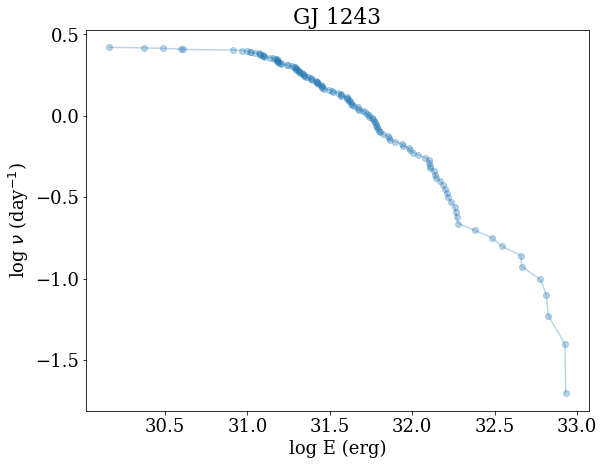

In [33]:
# TESS Luminosity
LUMIN = 31.061790465873248 # from "padova_lum" notebook
LUMIN_err = 0.039444830755122
# Kepler Luminosity
E_POINT = 30.67828435767249 # from "padova_lum" notebook
E_POINT_err = 0.04457627419541614
gj1243_dir = '../gj1243_10yrs/'

file = gj1243_dir + 'gj1243_tess.dat.fbeye'
colnames = ('Event_ID', 'Start_INDX', 'Stop_INDX', 't_peak', 't_start', 't_stop', 't_rise', 't_decay', 
            'Flux_peak', 'Equiv_Dur', 'S/N', 'CPLX_flg', 'MLTPK_flg', 'MLTPK_num', 't_MLTPK', 'L_mltpk', 
            'MLTPK_INDX', 'quies','x')

fbeye = pd.read_table(file, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row

file2 = gj1243_dir + 'gj1243_tess15.dat.fbeye'
fbeye2 = pd.read_table(file2, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row


file = gj1243_dir + 'tess2019198215352-s0014-0000000273589987-0150-s_lc.fits'
tbl = Table.read(file, format='fits')
q = tbl['QUALITY'] == 0

file2 = gj1243_dir + 'tess2019226182529-s0015-0000000273589987-0151-s_lc.fits'
tbl2 = Table.read(file2, format='fits')
q2 = tbl2['QUALITY'] == 0
dt = np.nanmedian(np.diff(tbl['TIME'][q]))

ED = np.sort(np.concatenate((fbeye['Equiv_Dur'].values, fbeye2['Equiv_Dur'].values)))[::-1]
TOTDUR = dt * (sum(q) + sum(q2)) # days

ffd_x = np.log10(ED) + LUMIN
ffd_y = np.log10(np.arange(1, len(ED)+1) / TOTDUR)

plt.figure(figsize=(9,7))
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.3)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
plt.title('GJ 1243')

In [34]:
# gj1243 : G-J = 11.55090 - 8.586
# YZCMi : G-J =  9.6807 - 6.58

print(11.55090 - 8.586, 9.6807 - 6.58)

2.9649 3.1007


/Users/james/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


Text(0, 0.5, 'log $\\nu$ (day$^{-1}$)')

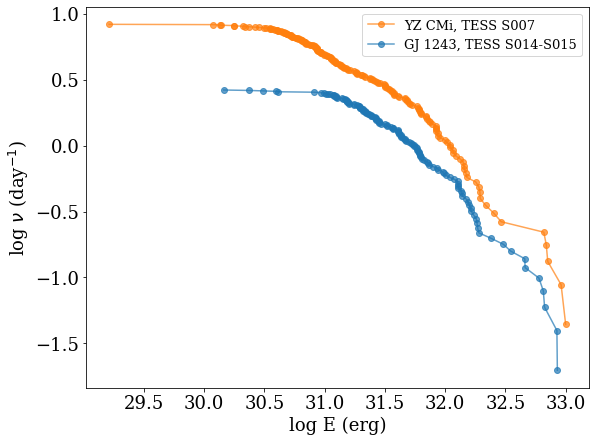

In [35]:
LUMINY = 31.00192752813018 # from updated notebook (gj1243_10yrs/spectra/padova_lum)
LUMINY_err = 0.22985294989763078

file = 'tess2019006130736-s0007-0000000266744225-0131-s_lc.fits.dat.fbeye'
fbeyeY = pd.read_table(file, sep='\s+', comment='#', names=colnames)[1:] # skip the first junk row

file = 'tess2019006130736-s0007-0000000266744225-0131-s_lc.fits'
tblY = Table.read(file, format='fits')
qY = tblY['QUALITY'] == 0
dt = np.nanmedian(np.diff(tblY['TIME'][qY]))

####
EDY = np.sort(fbeyeY['Equiv_Dur'].values)[::-1]
TOTDURY = dt * sum(qY) # days

ffd_xY = np.log10(EDY) + LUMINY
ffd_yY = np.log10(np.arange(1, len(EDY)+1) / TOTDURY)

plt.figure(figsize=(9,7))
plt.plot(ffd_xY, ffd_yY, '-o', color='C1', alpha=0.7, label='YZ CMi, TESS S007')
plt.plot(ffd_x, ffd_y, '-o', color='C0', alpha=0.7, label='GJ 1243, TESS S014-S015')
plt.legend(fontsize=13)
plt.xlabel('log E (erg)')
plt.ylabel(r'log $\nu$ (day$^{-1}$)')
# plt.title('GJ 1243')

2.772606015570289


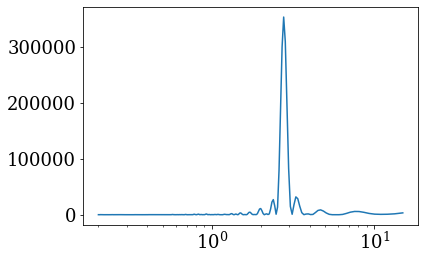

In [52]:
# plt.plot(tblY['TIME'][qY], tblY['PDCSAP_FLUX'][qY])
import exoplanet as xo

lnp = xo.lomb_scargle_estimator(tblY['TIME'][qY].data, tblY['PDCSAP_FLUX'][qY].data, min_period=0.2, max_period=15)

freq, pwr = lnp['periodogram']
plt.plot(1./freq, pwr)
plt.xscale('log')

print(lnp['peaks'][0]['period'])

In [36]:
import sys
sys.path
sys.path.append('/Users/james/python/FFD/')
from FFD import FFD, FlareKernel

#gj1243
ffd_x,ffd_y,ffd_xerr,ffd_yerr = FFD(np.concatenate((fbeye['Equiv_Dur'].values, 
                                    fbeye2['Equiv_Dur'].values)), TOTEXP=TOTDUR, Lum=LUMIN, 
                    dur=np.concatenate((fbeye['t_stop'].values-fbeye['t_start'].values, 
                                        fbeye2['t_stop'].values-fbeye2['t_start'].values)), 
                    fluxerr=np.nanmedian(tbl['PDCSAP_FLUX_ERR'][q] / np.nanmedian(tbl['PDCSAP_FLUX'][q])),logY=False)

#yzcmi
ffd_xY,ffd_yY,ffd_xerrY,ffd_yerrY = FFD(fbeyeY['Equiv_Dur'].values, TOTEXP=TOTDURY, Lum=LUMINY, 
                                        dur=fbeyeY['t_stop'].values-fbeyeY['t_start'].values, 
                fluxerr=np.nanmedian(tblY['PDCSAP_FLUX_ERR'][qY] / np.nanmedian(tblY['PDCSAP_FLUX'][qY])),logY=False )


/Users/james/python/FFD/FFD.py:55: RuntimeWarning: invalid value encountered in log10
  ffd_x = np.log10(ED[ss]) + Lum


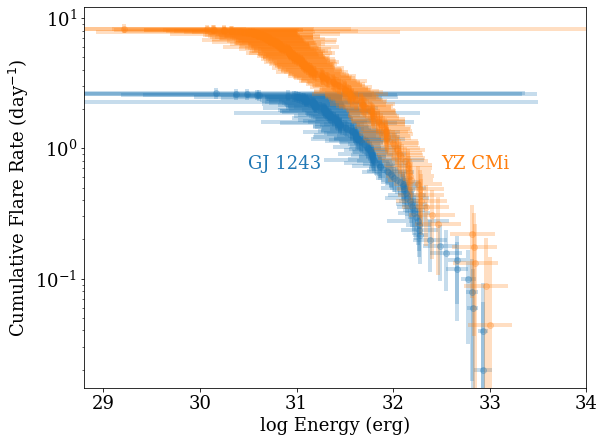

In [44]:
plt.figure(figsize=(9,7))

plt.errorbar(ffd_x, (ffd_y), xerr=np.sqrt(ffd_xerr**2+LUMIN_err**2), 
             yerr=ffd_yerr, 
             color='C0', alpha=0.25, linestyle='none', lw=4, marker='o')

plt.errorbar(ffd_xY, (ffd_yY), xerr=np.sqrt(ffd_xerrY**2+LUMINY_err**2), 
             yerr=ffd_yerrY, 
             color='C1', alpha=0.25, linestyle='none', lw=4, marker='o')


plt.yscale('log')

plt.xlabel('log Energy (erg)')
plt.ylabel(r'Cumulative Flare Rate (day$^{-1}$)')
# plt.title('GJ 1243 (M4, P$_{rot}$=0.59d)', fontsize=14)

# plt.text(31.5, 5, 'Kepler',color='k')
plt.text(30.5, 0.7,'GJ 1243', color='C0')
plt.text(32.5, 0.7,'YZ CMi', color='C1')
plt.xlim(28.8,34)

plt.savefig('YZCMI_vs_GJ1243.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [46]:
LUMINY

31.00192752813018